In [1]:
import tensorflow as tf
from scipy.stats import norm
import numpy as np
import pandas as pd

Black-Scholes data generation

In [2]:
S = np.linspace(50, 650, 600*4 + 1)
K = np.linspace(25, 750, 725*4 + 1)
dt = np.arange(1, 365 + 1) / 365
sigma = np.linspace(5, 90, 85 * 100 + 1) / 100
r = np.linspace(1, 5, 401) / 100

In [3]:
def gen_data(n=10**6, seed=0):
    rng = np.random.default_rng(seed=seed)
    df = np.zeros(shape=(n, 6))

    df[:, 0] = rng.choice(S, size=n)
    df[:, 1] = np.floor(rng.uniform(0.65 * df[:, 0], 1.35 * df[:, 0], size=n))
    df[:, 2] = rng.choice(dt, size=n)
    df[:, 3] = rng.choice(sigma, size=n)
    df[:, 4] = rng.choice(r, size=n)

    d_1 = (np.log(df[:, 0] / df[:, 1]) + (df[:, 4] + df[:, 3] ** 2 / 2) * df[:, 2]) / (df[:, 3] * np.sqrt(df[:, 2]))
    d_2 = d_1 - df[:, 3] * np.sqrt(df[:, 2])

    df[:, 5] = df[:, 0] * norm.cdf(d_1) - df[:, 1] * np.exp(-df[:, 4] * df[:, 2]) * norm.cdf(d_2)

    df[:, 0] /= df[:, 1]
    df[:, 5] /= df[:, 1]
    return df

In [4]:
train_df, test_df = gen_data(2 * 10**5), gen_data(10**5, seed=1)

train_X, train_y = train_df[:, :-1], train_df[:, -1]
test_X, test_y = test_df[:, :-1], test_df[:, -1]

Tensorflow NN

In [5]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(
            1,
            activation="elu",
        ),
    ]
)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.MSE,
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)
model.fit(train_X[:, [0, 2, 3, 4]], train_y, batch_size=2**8, epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0713
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.7826e-05 - mean_absolute_error: 0.0068
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6925e-05 - mean_absolute_error: 0.0053
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7274e-05 - mean_absolute_error: 0.0046
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0824e-05 - mean_absolute_error: 0.0042
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6845e-05 - mean_absolute_error: 0.0039
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3872e-05 - mean_absolute_error: 0.0037
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0819e-05 - mean_absolute_error: 0.0034
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6142e-05 - mean_absolute_error: 0.0030
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4412e-05 - mean_absolute_error: 

In [7]:
save_model = False
load_model = True
if save_model:
    model.save("bs_nn.keras")
if load_model:
    model = tf.keras.models.load_model("bs_nn.keras")

In [8]:
output_df = pd.DataFrame(test_X.copy(), columns=["S", "K", "dt", "sigma", "r"])
output_df["price"] = test_y.copy()
output_df["model_price"] = model.predict(test_X[:, [0, 2, 3, 4]]).flatten()

output_df["S"] *= output_df["K"]
output_df["price"] *= output_df["K"]
output_df["model_price"] *= output_df["K"]

output_df["residual"] = output_df["price"] - output_df["model_price"]
output_df["relative_error"] = output_df["residual"] / output_df["price"]
output_df["abs_relative_error"] = np.abs(output_df["residual"] / output_df["price"])
output_df

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


,S,K,dt,sigma,r,price,model_price,residual,relative_error,abs_relative_error
0,334.00,336.0,0.213699,0.7231,0.0398,44.702020,44.694775,0.007246,0.000162,0.000162
1,357.00,335.0,0.852055,0.5207,0.0292,81.121433,81.174889,-0.053457,-0.000659,0.000659
2,503.25,522.0,0.627397,0.4260,0.0279,63.335483,63.308424,0.027059,0.000427,0.000427
3,620.50,566.0,0.383562,0.5731,0.0278,116.802638,116.699579,0.103059,0.000882,0.000882
4,70.75,78.0,0.073973,0.2936,0.0252,0.333436,0.351675,-0.018239,-0.054701,0.054701
...,...,...,...,...,...,...,...,...,...,...
99995,547.50,421.0,0.665753,0.6541,0.0470,184.666206,184.893043,-0.226837,-0.001228,0.001228
99996,226.25,162.0,0.482192,0.5309,0.0262,72.752517,72.899839,-0.147322,-0.002025,0.002025
99997,172.50,124.0,0.227397,0.3288,0.0367,49.655662,49.686006,-0.030344,-0.000611,0.000611
99998,55.25,40.0,0.457534,0.8345,0.0167,20.021692,20.052197,-0.030505,-0.001524,0.001524


MSE on test set

In [9]:
(output_df['residual'] ** 2).mean()

0.03600662132026766

In [10]:
(output_df.loc[output_df['residual'] > np.percentile(output_df['residual'], 95)]).sort_values('residual', ascending=False)

,S,K,dt,sigma,r,price,model_price,residual,relative_error,abs_relative_error
20356,558.75,550.0,0.002740,0.0603,0.0353,8.803189,7.307983,1.495206,0.169848,0.169848
50692,638.50,625.0,0.005479,0.1087,0.0184,13.568983,12.247730,1.321253,0.097373,0.097373
68312,576.25,622.0,0.010959,0.8582,0.0282,5.943070,4.652049,1.291021,0.217231,0.217231
37642,647.00,687.0,0.005479,0.8395,0.0226,3.698271,2.607570,1.090701,0.294922,0.294922
95655,372.25,399.0,0.008219,0.8412,0.0497,2.925098,1.889255,1.035844,0.354123,0.354123
...,...,...,...,...,...,...,...,...,...,...
66320,541.00,528.0,0.958904,0.1107,0.0478,45.486333,45.347777,0.138556,0.003046,0.003046
41680,626.75,413.0,0.158904,0.1453,0.0287,215.629218,215.490690,0.138528,0.000642,0.000642
26699,576.75,756.0,0.624658,0.1298,0.0242,0.138520,0.000000,0.138520,1.000000,1.000000
38452,460.00,578.0,0.024658,0.8991,0.0357,1.644258,1.505788,0.138470,0.084215,0.084215


Plots

In [11]:
import matplotlib.pyplot as plt

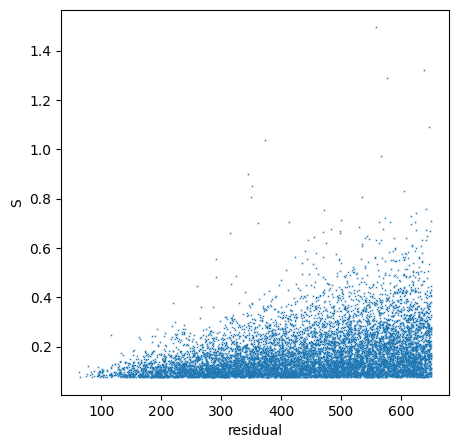

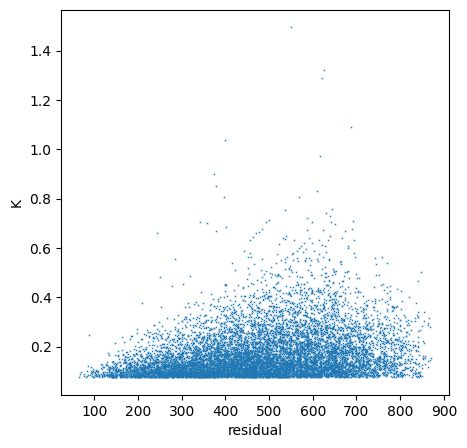

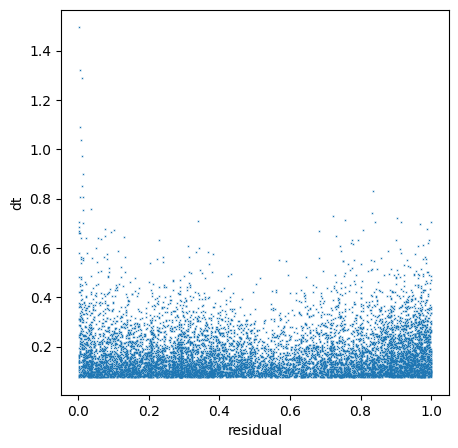

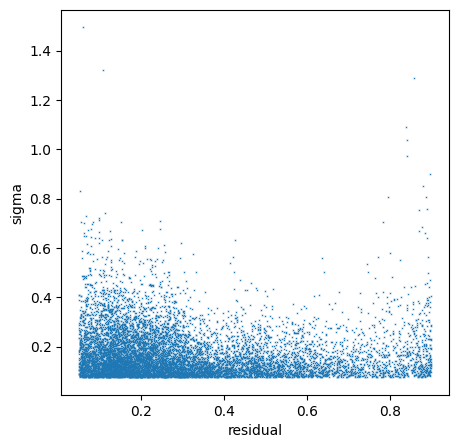

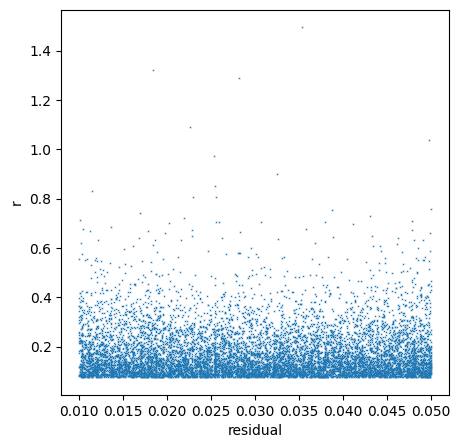

In [12]:
plot_df = output_df.loc[output_df['residual'] > np.percentile(output_df['residual'], 90)]

for col in ["S", "K", "dt", "sigma", "r"]:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(plot_df[col], plot_df["residual"], s=0.1, marker="x")
    ax.set_xlabel("residual")
    ax.set_ylabel(col)
    plt.show()

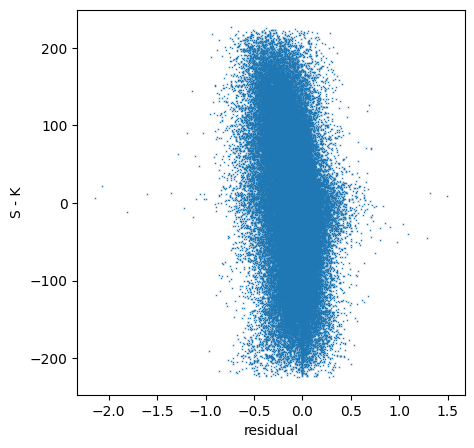

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(output_df["residual"], output_df["S"] - output_df["K"], s=0.1, marker="x")
ax.set_xlabel("residual")
ax.set_ylabel("S - K")
plt.show()